# DM - Final - Mohamad Taha Fakharian
In this project, we're going to explore a dataset related to Gorkha's building features and the degree that they got damaged in the earthquake. We first apply some preprocessing on the dataset and then try to predict this damage using Support Vector Machine and Multi-layer Perceptron models and see if we can improve the models or not. Finally, we'll use AutoFeat and make a new model based on it. 

First we need to import some useful libraries for data manipulating. Before that, we need to install 'autofeat' library for last phase of the project. Let's go! 

In [ ]:
!python3 -m pip install autofeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now let's import the necessary libraries and modules for the entire project:

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Keras/tensorflow modules
import keras
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf

# Autofeat modules
from autofeat import AutoFeatClassifier

We used google colab to be able to train the models. We need to import the datasets from google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's import the featues and labels and save them in two dataframes:

In [ ]:
values = pd.read_csv('drive/My Drive/Uni/Term6/DM/values.csv')
labels = pd.read_csv('drive/My Drive/Uni/Term6/DM/labels.csv')

Let's take a look at the features and labels:

In [ ]:
values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


We need to merge these two dataframes on building id, then drop the building id and seperate the features and the labels from eachother(for later cases). Let's go:

In [ ]:
total = values.merge(labels, on='building_id', how='left')

Now we'll get rid of building id. Pay attention! Id is not considered as a good feature, since it can't help models generalize well and can cause overfitting.

In [ ]:
total.drop(['building_id'], axis=1, inplace=True)

In [ ]:
X, y = total.drop(['damage_grade'], axis=1, inplace=False) , total['damage_grade']

Finally, let's take a look at feature and labels' dataframes:

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y.head()

0    3
1    2
2    3
3    2
4    3
Name: damage_grade, dtype: int64

We are done for now. Let's start with preprocessing!

##Phase 1: Preparing features and preprocessing
Before anything new, let's see how many features have NaN values. If there is any, we need to do something for that:

In [ ]:
X.isna().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

Fortunately, there is no missing value. Let's see the ditribution of features. We'll use this knowledge later for feature selection:

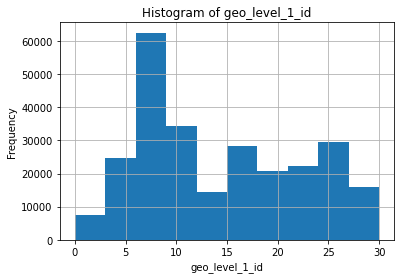

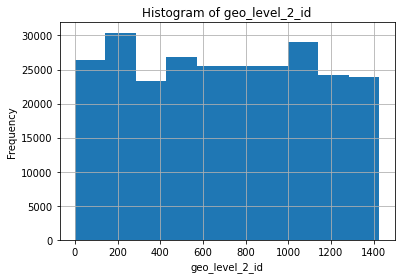

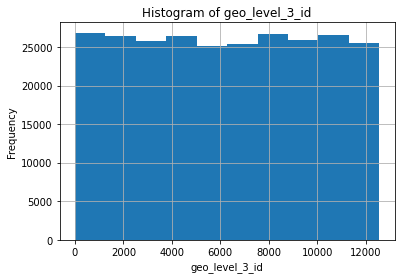

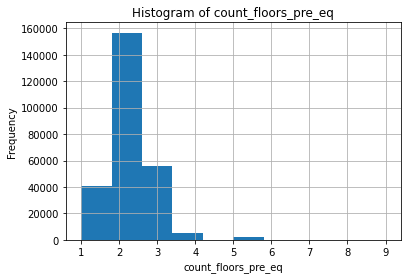

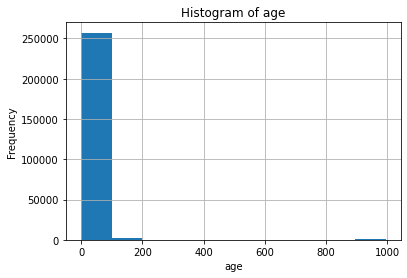

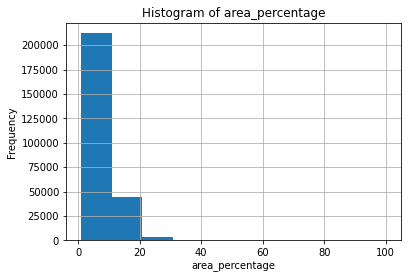

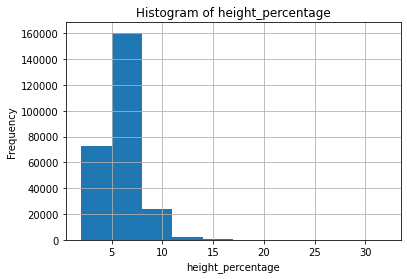

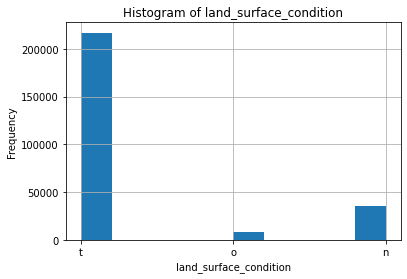

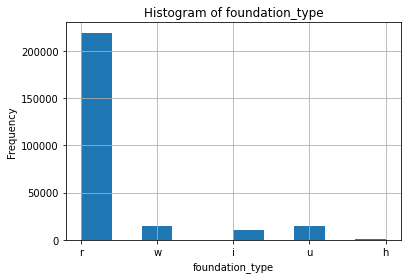

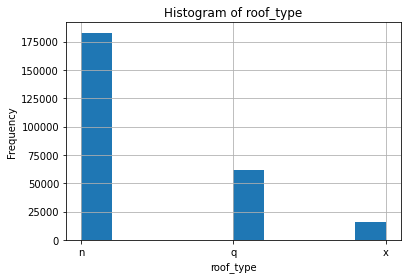

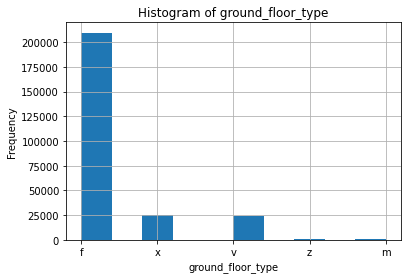

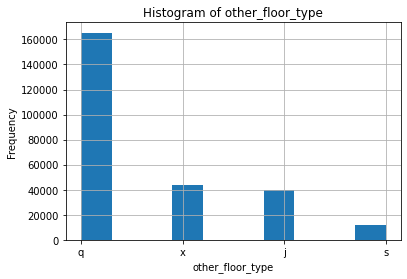

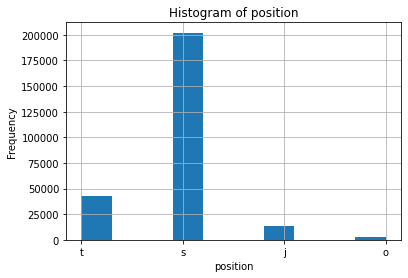

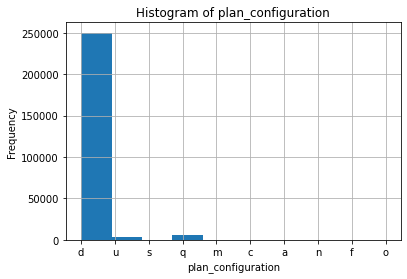

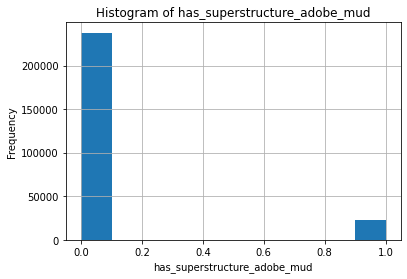

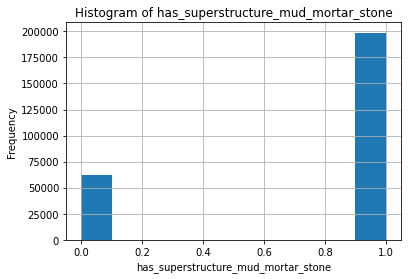

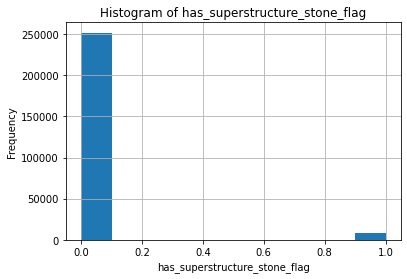

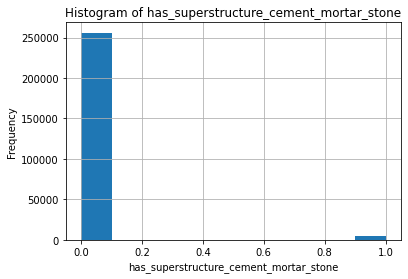

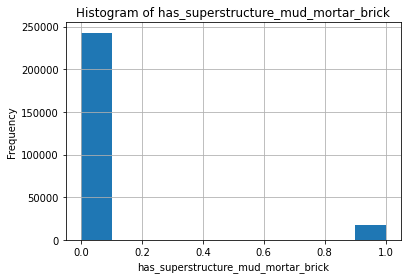

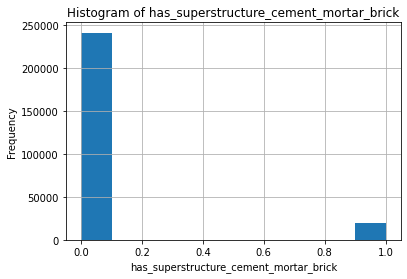

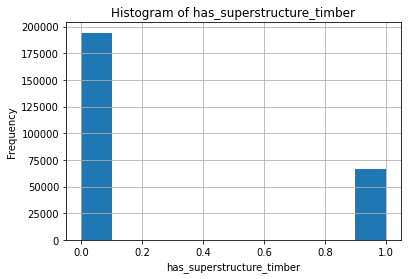

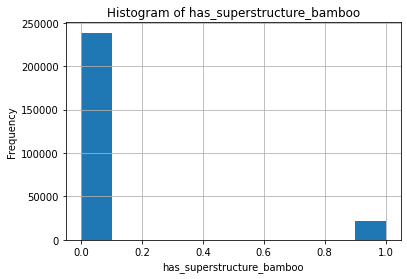

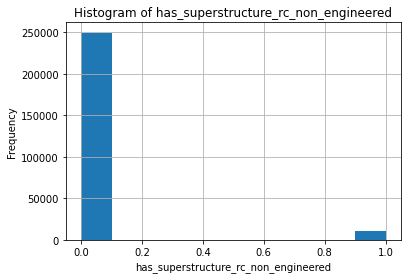

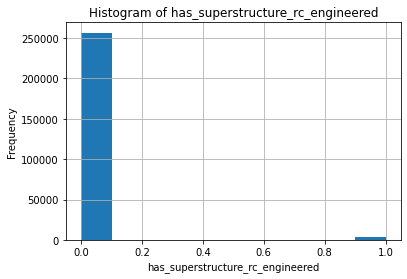

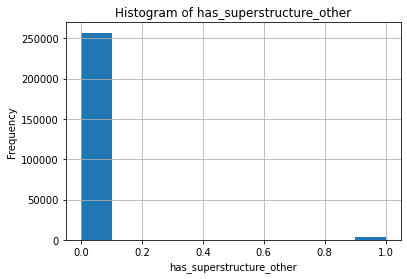

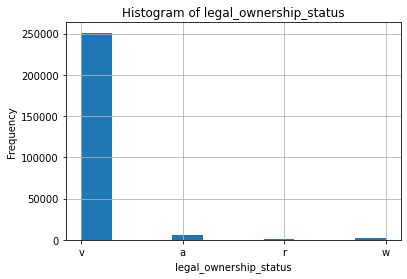

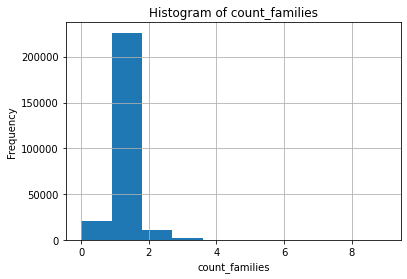

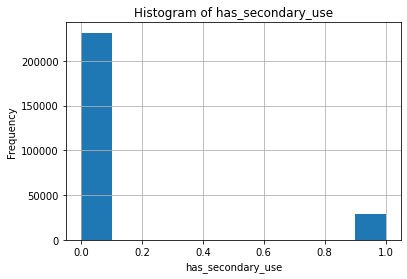

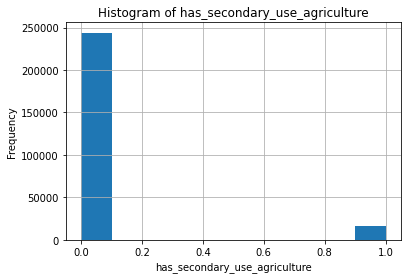

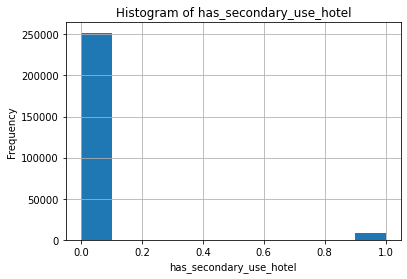

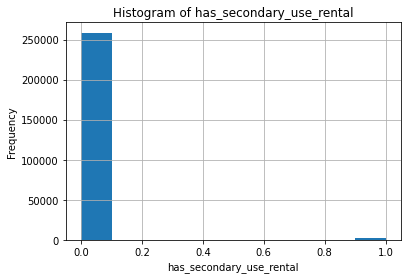

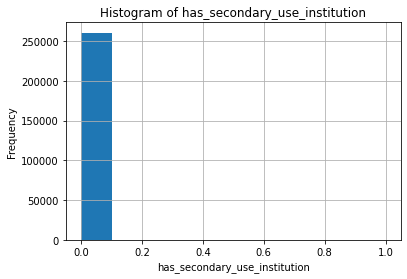

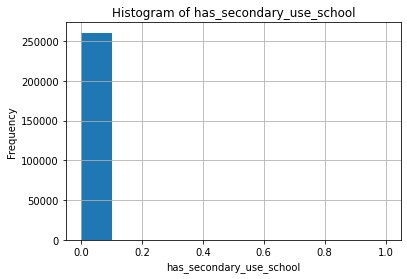

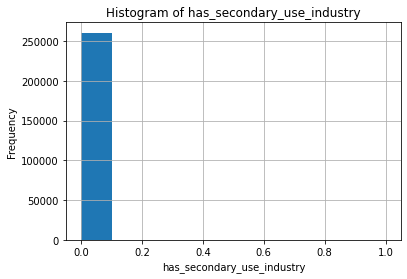

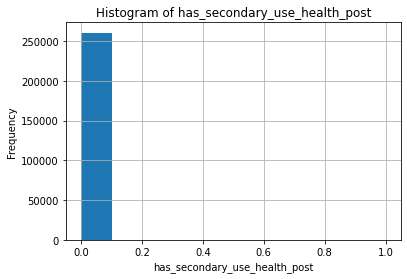

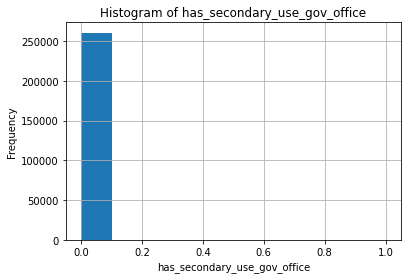

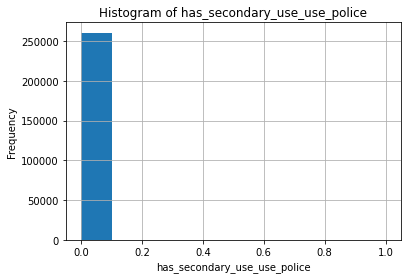

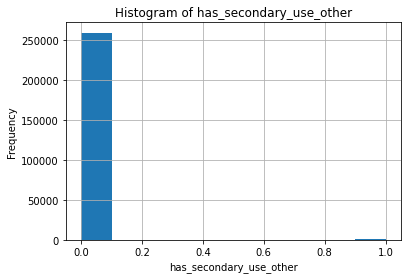

In [ ]:
for feature in X:
    plt.figure()
    plt.title('Histogram of {}'.format(feature))
    X[feature].hist()
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    plt.show()

Let's see the balance of labels:

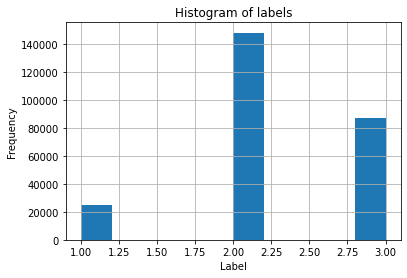

In [ ]:
plt.figure()
plt.title('Histogram of labels')
y.hist()
plt.ylabel('Frequency')
plt.xlabel('Label')
plt.show()

As you can see, we have label imbalance problem, which should be handled.

Now let's try normalization/standardization. Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling. Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks. Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

Scaling avoids raw data and various problems of datasets by creating new values and maintaining general distribution as well as a ratio in data. Further, it also improves the performance and accuracy of machine learning models using various techniques and algorithms.

Since our numerical values don't follow a guassian distribution, we use normalization method:

In [ ]:
for feature in X:
    if is_numeric_dtype(X[feature]):
        scaled = MinMaxScaler().fit(X[[feature]])
        X[feature] = scaled.transform(X[[feature]])

Let's see which features are categorical:

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id                          260601 non-null  float64
 1   geo_level_2_id                          260601 non-null  float64
 2   geo_level_3_id                          260601 non-null  float64
 3   count_floors_pre_eq                     260601 non-null  float64
 4   age                                     260601 non-null  float64
 5   area_percentage                         260601 non-null  float64
 6   height_percentage                       260601 non-null  float64
 7   land_surface_condition                  260601 non-null  object 
 8   foundation_type                         260601 non-null  object 
 9   roof_type                               260601 non-null  object 
 10  ground_floor_type                       2606

There are several methods to convert categorical data into numerical data:

- Label Encoding: Assigining numbers to each categorical value.
- One Hot Encoding: Adding new columns for each categorical value and assigining a binary vector to each row.

Label Encoding isn't a good approach when we have no particular ordering in our categories. In such cases, we can use One Hot Encoding which takes a lot of memory since it is adding a new column for each new category. Since total number of possible values for categorical features isn't that high and there isn't an obvious order in the data, we'll use one-hot encoding for these features(The values for these categorical features doesn't have any obvious order and they're related to mining engineering). We'll apply this method on a copy of feature's dataframe(since we need the raw features in the last phase). Let's see how they work:

In [ ]:
X_ = X.copy()
for col in X_.columns:
    if X_[col].dtype == 'object':
        dummy = pd.get_dummies(X_[col],prefix=col)
        X_=pd.concat([X_, dummy], axis=1)
        X_.drop(col, axis=1,inplace=True)

Let's make sure that no categorical features remained among the features:

In [ ]:
X_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 68 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id                          260601 non-null  float64
 1   geo_level_2_id                          260601 non-null  float64
 2   geo_level_3_id                          260601 non-null  float64
 3   count_floors_pre_eq                     260601 non-null  float64
 4   age                                     260601 non-null  float64
 5   area_percentage                         260601 non-null  float64
 6   height_percentage                       260601 non-null  float64
 7   has_superstructure_adobe_mud            260601 non-null  float64
 8   has_superstructure_mud_mortar_stone     260601 non-null  float64
 9   has_superstructure_stone_flag           260601 non-null  float64
 10  has_superstructure_cement_mortar_stone  2606

We see that there are too many features. We try to apply some dimensionality reduction techniques.

Here are some of the benefits of applying dimensionality reduction to a dataset:

- Space required to store the data is reduced as the number of dimensions comes down
- Less dimensions lead to less computation/training time
- Some algorithms do not perform well when we have a large dimensions. So reducing these dimensions needs to happen for the algorithm to be useful
- It takes care of multicollinearity by removing redundant features. For example, you have two variables – ‘time spent on treadmill in minutes’ and ‘calories burnt’. These variables are highly correlated as the more time you spend running on a treadmill, the more calories you will burn. Hence, there is no point in storing both as just one of them does what you require
- It helps in visualizing data. As discussed earlier, it is very difficult to visualize data in higher dimensions so reducing our space to 2D or 3D may allow us to plot and observe patterns more clearly

Dimensionality reduction can be done in two different ways:

- By only keeping the most relevant variables from the original dataset (this technique is called feature selection)
- By finding a smaller set of new variables, each being a combination of the input variables, containing basically the same information as the input variables (this technique is called dimensionality reduction)

According to these explanations, let's see the gain of each feature. We use 'mutual_info_classif' from sklearn to see which features are the most and least effective:

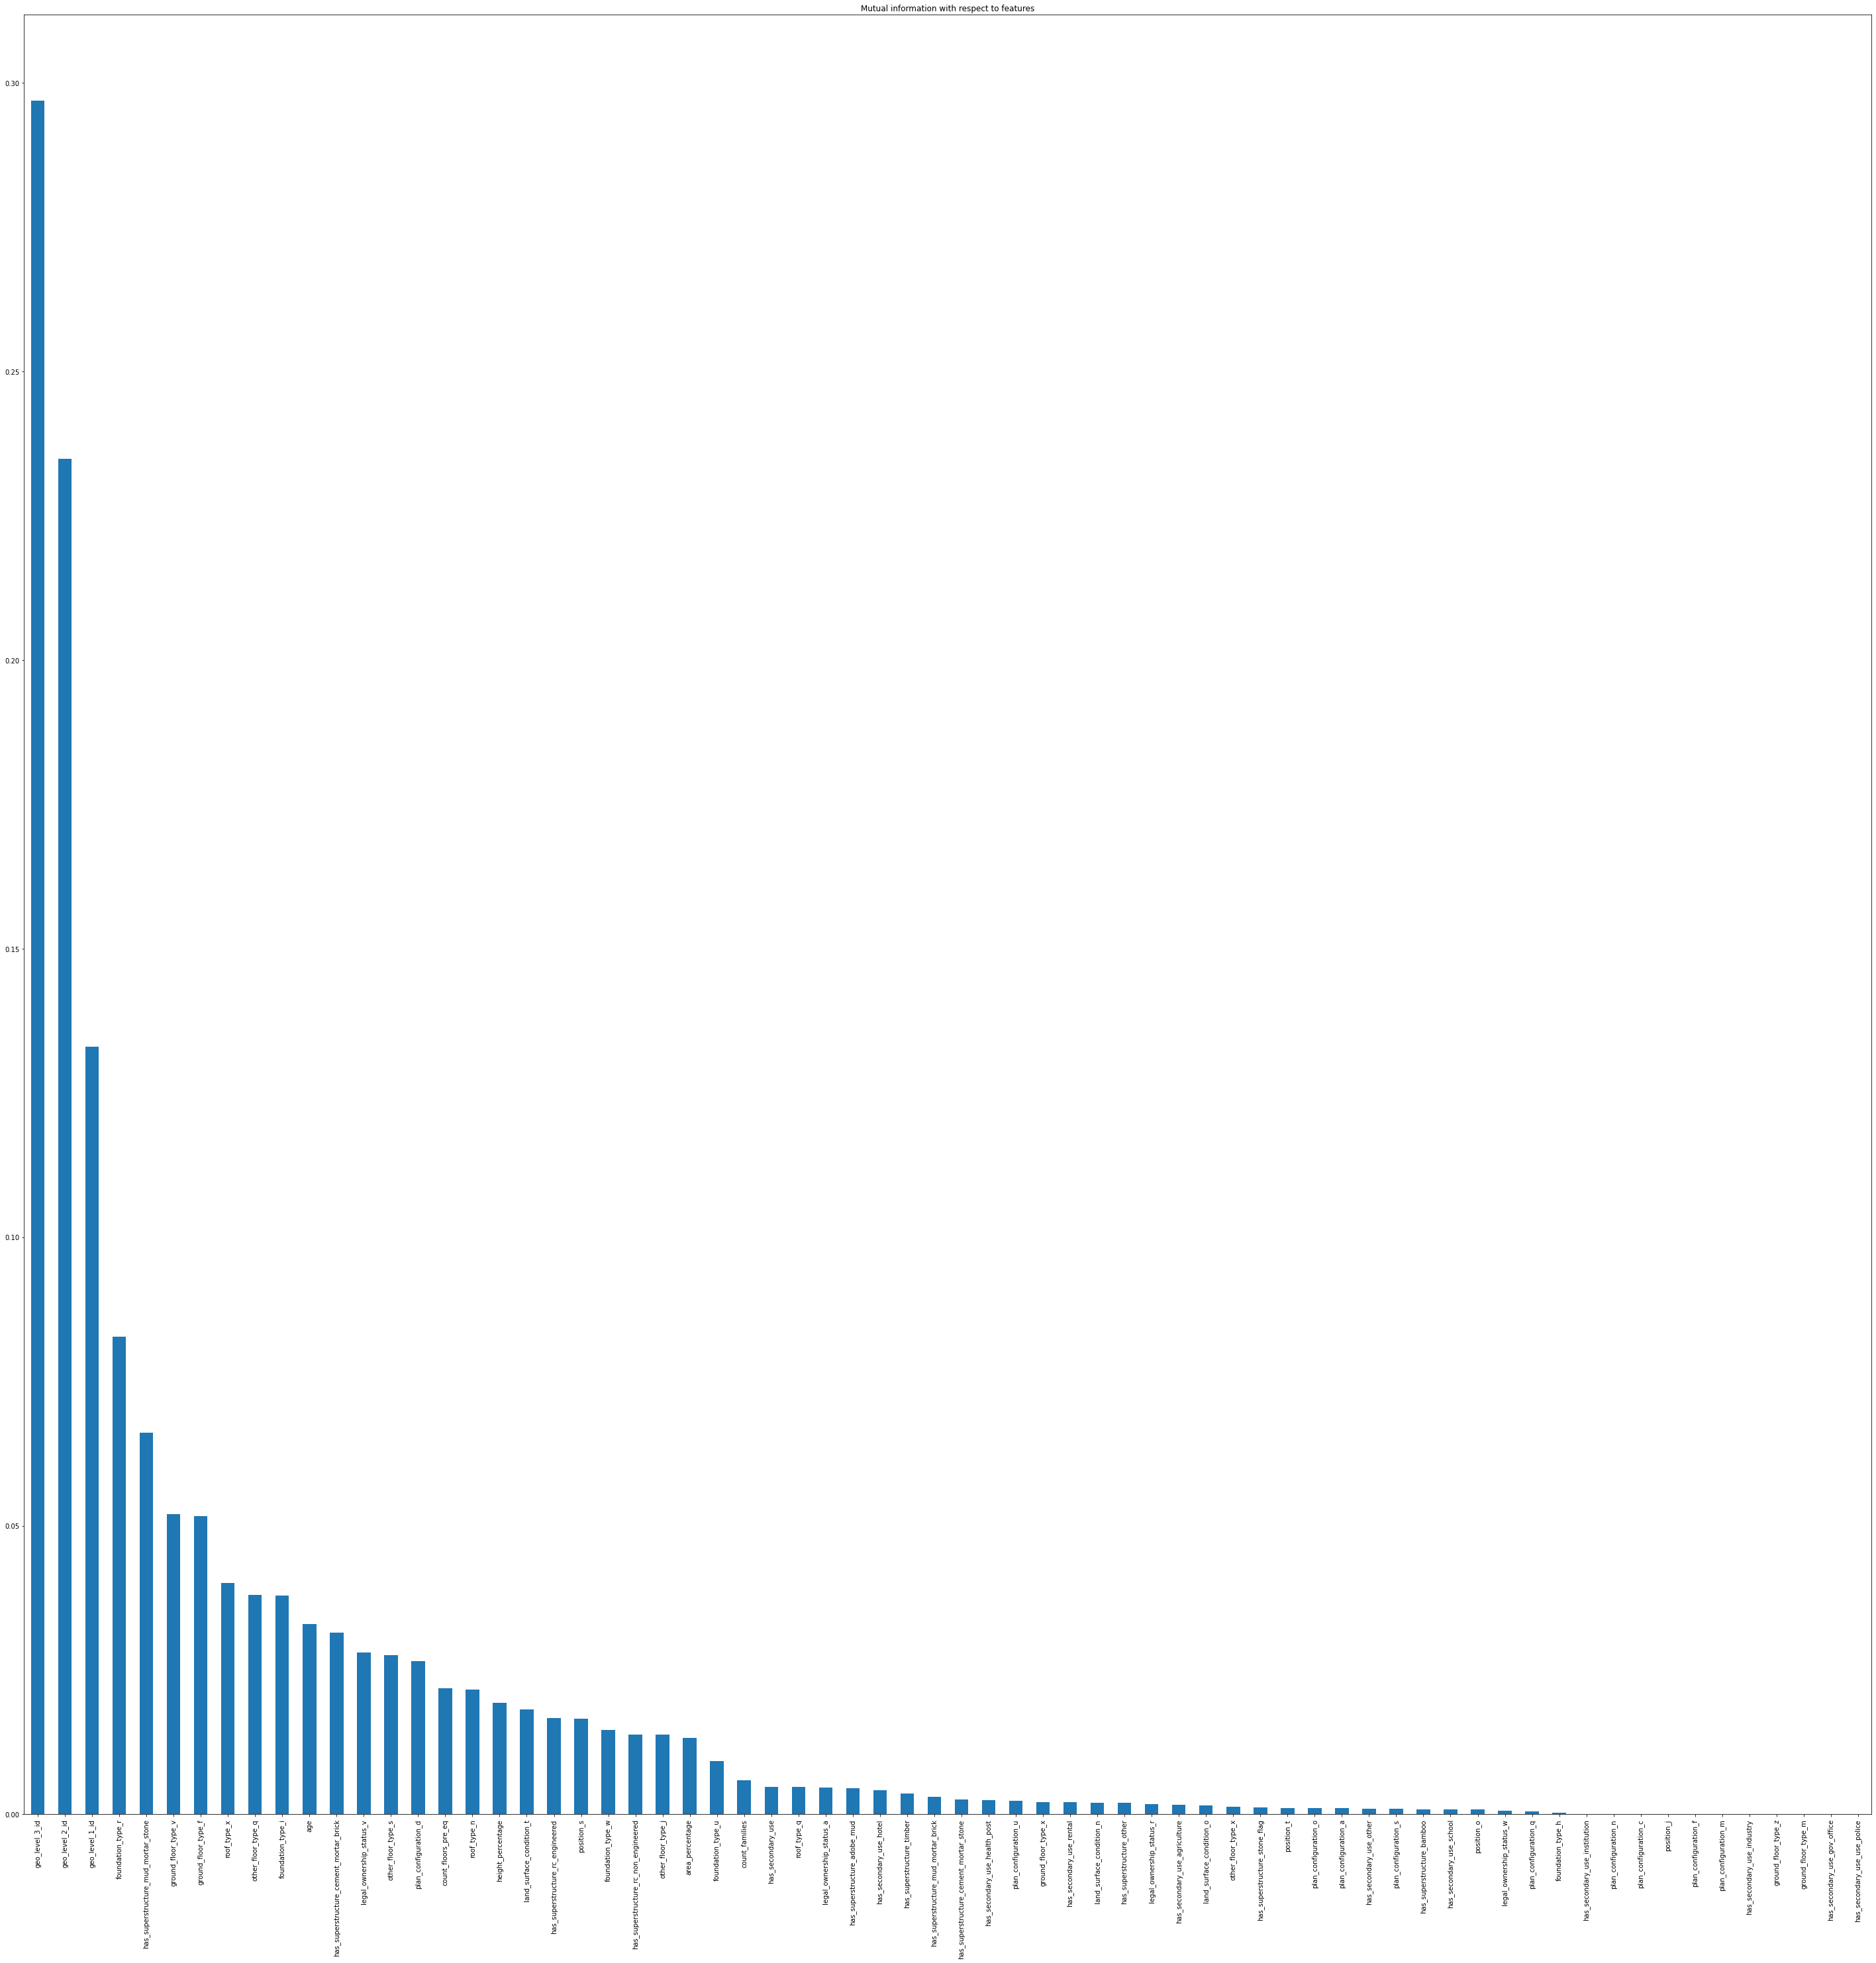

In [ ]:
info = mutual_info_classif(X_, y)
ig = pd.Series(info)
ig.index = X_.columns
ig.sort_values(ascending = False, inplace = True)

plt.title('Mutual information with respect to features')
ig.plot.bar(figsize=(50,50))
plt.show()

As you can see, many features don't have good information and we can get rid of them. Let's use a random forest model to see the importance of each feature too. Random Forests are often used for feature selection in a data science workflow. The reason is because the tree-based strategies used by random forests naturally ranks by how well they improve the purity of the node. This mean decrease in impurity over all trees (called gini impurity). Nodes with the greatest decrease in impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features:

In [ ]:
model = RandomForestClassifier(random_state=1, max_depth=25)
model.fit(X_, y)

RandomForestClassifier(max_depth=25, random_state=1)

Let's plot the importance of each feature in this model:

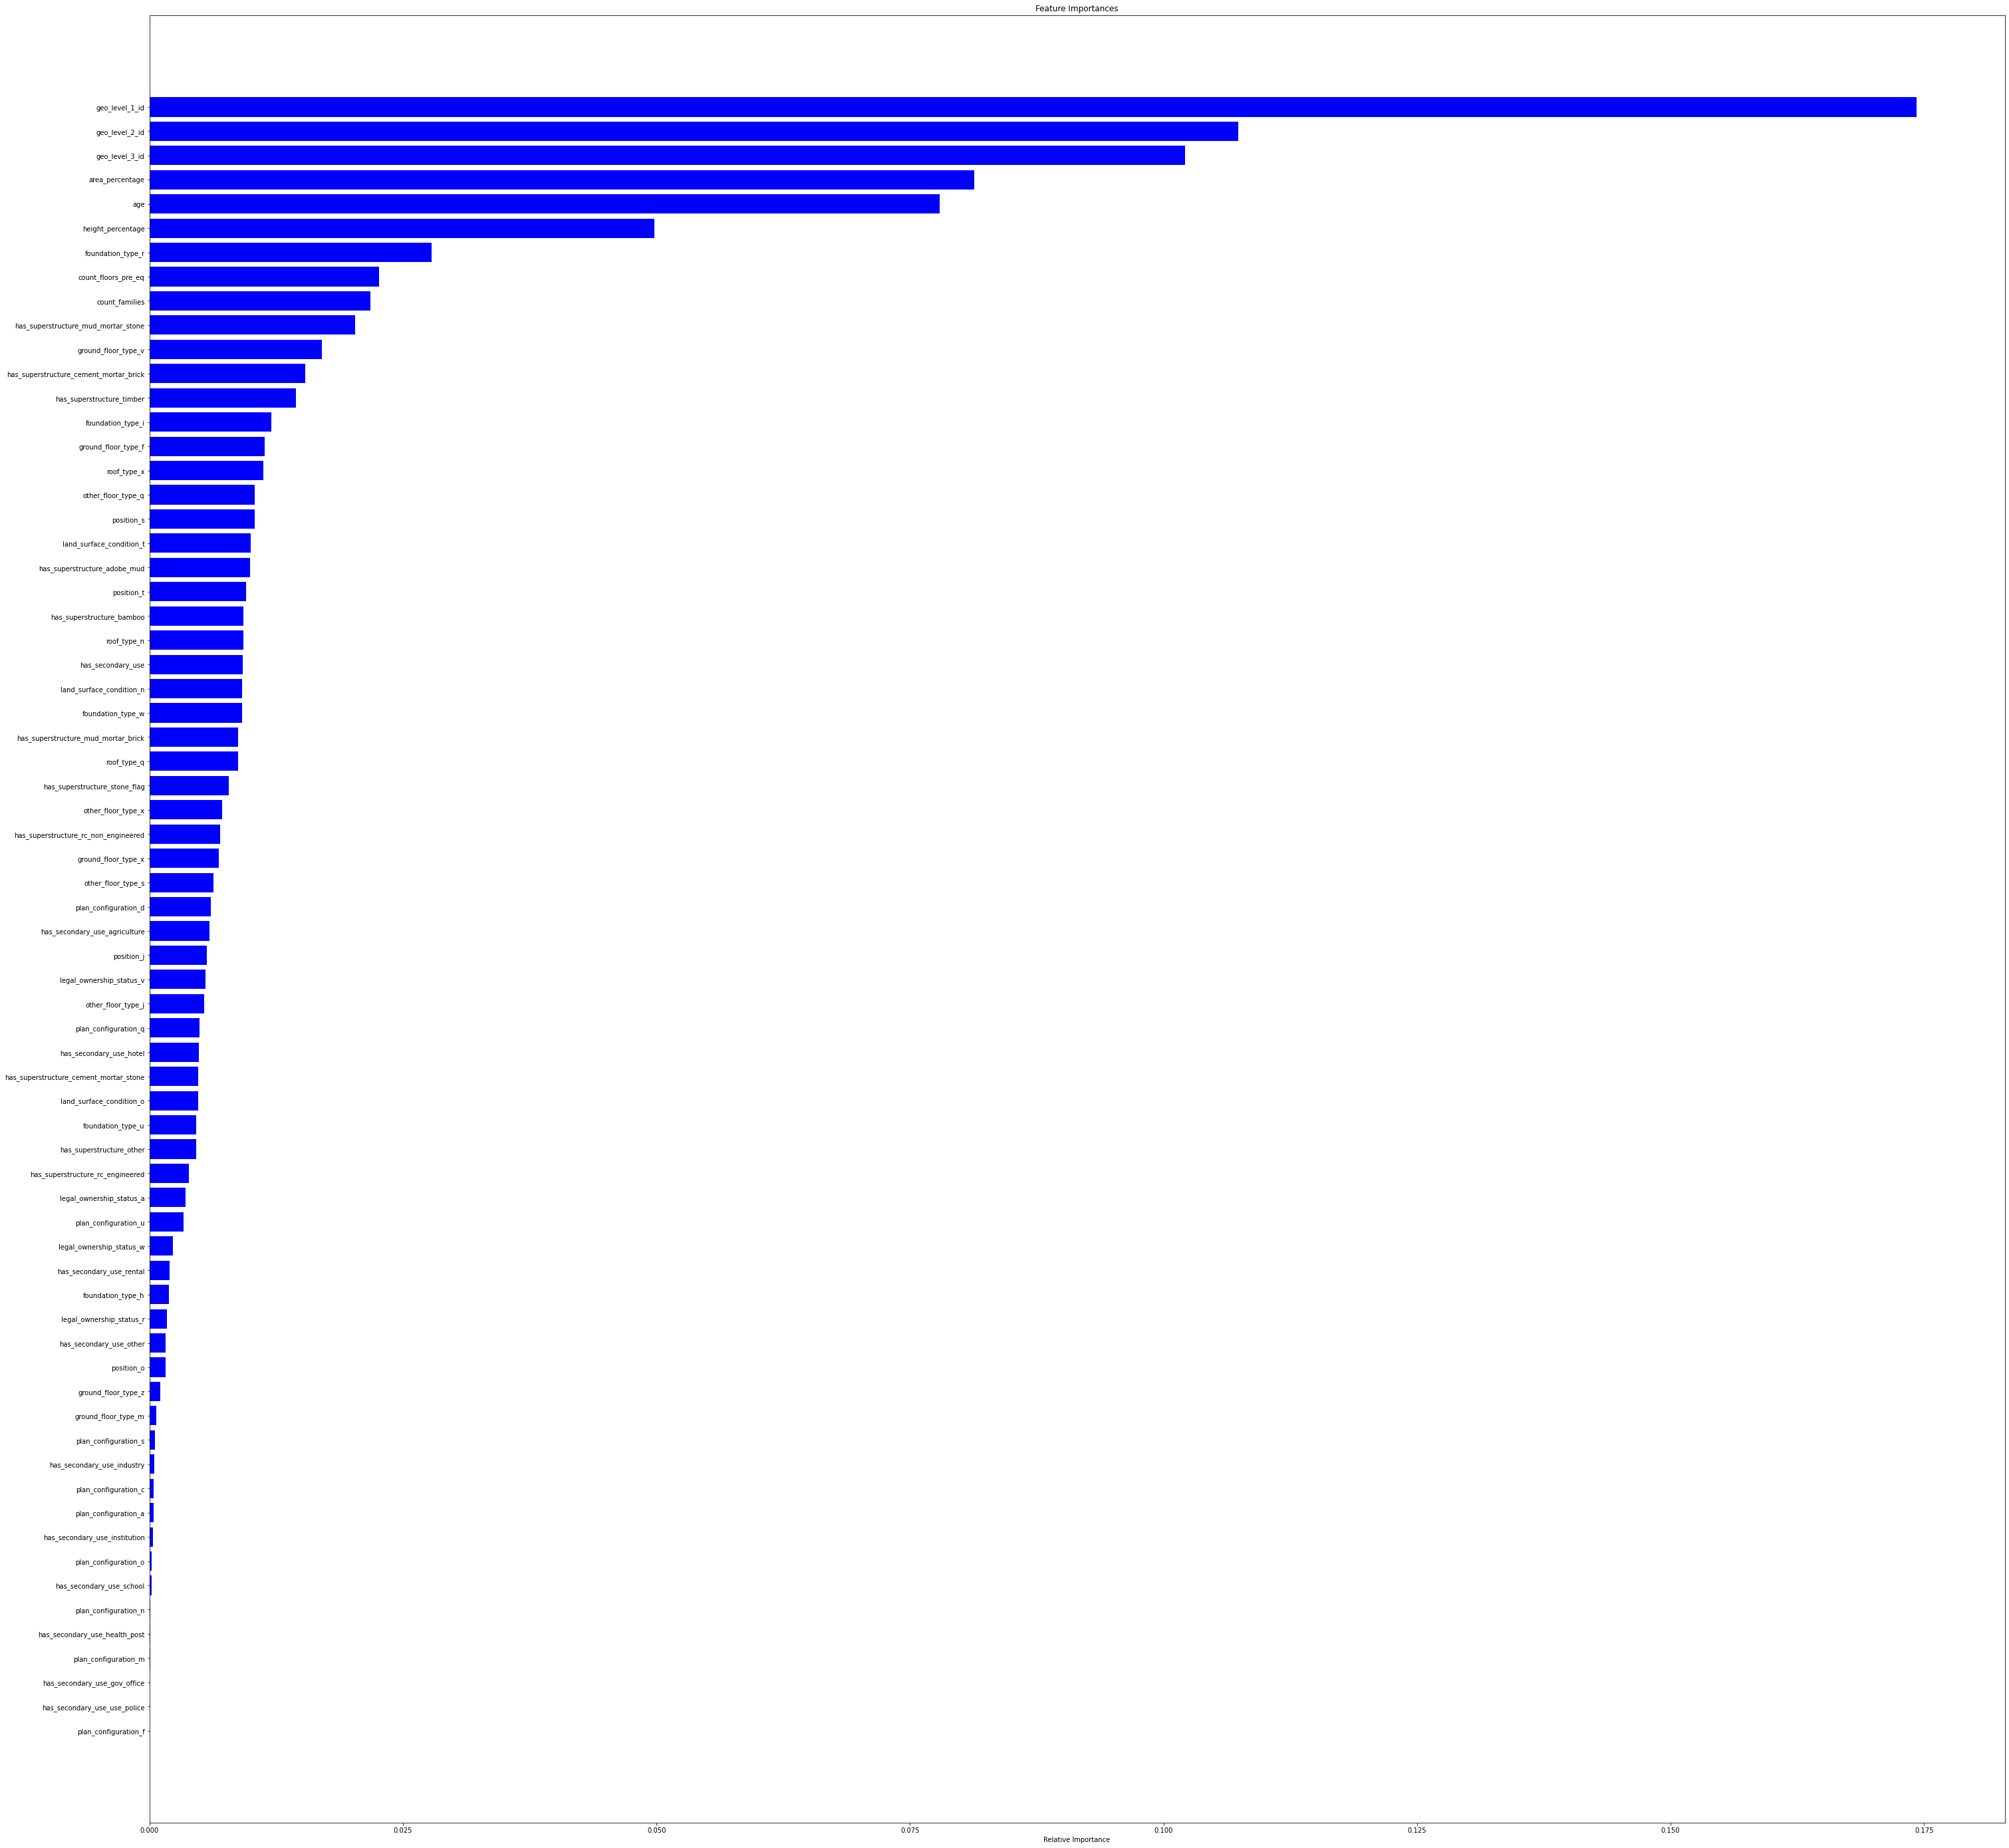

In [ ]:
features = X_.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(50,50))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Two plots are quiete the same. Now let's see the correlation of features and after that, decide how to reduce the dimension. First we create the correlation matrix:

In [ ]:
corr_matrix = X_.corr().abs()

Now we'll save the upper triangle matrix(because the matrix is symmetric):

In [ ]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

Now we'll see the high correlated features, using 0.85 as a threshold:

In [ ]:
high_correlated = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]

In [ ]:
high_correlated

['land_surface_condition_t', 'roof_type_q']

As you can see, there isn't that much correlation between the features, and since dimensionality techniques like PCA are useful when some features are correlated, we decide not to use these techniques. According to above, we choose to keep the top-25 features with highest importance to reduce the dimensionality. Let's do it!

In [ ]:
X_new = X_.copy()

for column in X_new.columns:
    if column not in ig[:25]:
        X_new.drop(columns=[column], axis=1, inplace=True)

Let's take a look at the new-preprocessed features:

In [ ]:
X_new.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_non_engineered,...,roof_type_n,roof_type_x,ground_floor_type_f,ground_floor_type_v,other_floor_type_j,other_floor_type_q,other_floor_type_s,position_s,plan_configuration_d,legal_ownership_status_v
0,0.200000,0.341275,0.970637,0.125,0.030151,0.050505,0.100000,1.0,0.0,0.0,...,1,0,1,0,0,1,0,0,1,1
1,0.266667,0.630694,0.223761,0.125,0.010050,0.070707,0.166667,1.0,0.0,0.0,...,1,0,0,0,0,1,0,1,1,1
2,0.700000,0.254380,0.714013,0.125,0.010050,0.040404,0.100000,1.0,0.0,0.0,...,1,0,1,0,0,0,0,0,1,1
3,0.733333,0.292922,0.850959,0.125,0.010050,0.050505,0.100000,1.0,0.0,0.0,...,1,0,1,0,0,0,0,1,1,1
4,0.366667,0.091801,0.118405,0.250,0.030151,0.070707,0.233333,0.0,0.0,0.0,...,1,0,1,0,0,0,0,1,1,1


Now we are ready for phase 2:

## Phase 2: Learning and choosing appropriate model
First we need to get some information about SVM and MLP models.

## SVM
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

The main hyperparameter of the SVM is the kernel. It maps the observations into some feature space. Ideally the observations are more easily (linearly) separable after this transformation. There are multiple standard kernels for this transformations, e.g. the linear kernel, the polynomial kernel and the radial kernel. The choice of the kernel and their hyperparameters affect greatly the separability of the classes (in classification) and the performance of the algorithm.

### The linear kernel
The linear kernel is $$K(x_i,x_j)=x′_ix_j$$

When using this kernel we only have one hyperparameter in SVM: The cost parameter C.

<center><img src='https://drive.google.com/uc?id=1tUmtFyqt2fRfTlIL0ieaJyNc3_u1UoAm'></center>

### The polynomial kernel
The polynomial kernel is $$K(x_i,x_j)=(r+γ⋅x′_ix_j)^d$$

Usually the parameter r is set to zero and γ to a fixed value, e.g. 1/n with n being the number of observations. Beside the cost parameter C the integer parameter d has to be tuned, usually values between 1 and 10 are chosen.

<center><img src='https://drive.google.com/uc?id=1g5Xaav6bEp7U5T2TQZyCcUkldMF7oJ_K'></center>


### The radial kernel
The radial kernel is $$K(x_i,x_j)=e^{γ⋅x′_ix_j}$$

This kernel is the most used and most successful kernel, due to the flexibility of separating observations with this method. Additionally to the cost parameter C, the hyperparameter γ has to be tuned. In the paper A practical guide to Support Vector Classifier they recommend to search C in the range $$[2^−5;2^{15}]$$ and γ in the range $$[2^{−15};2^3]$$

<center><img src='https://drive.google.com/uc?id=1FQZG_R3fkRS1GS3b1jnMiMw621KGM9gK'></center>


## MLP
A Multilayer Perceptron has input and output layers, and one or more hidden layers with many neurons stacked together. And while in the Perceptron the neuron must have an activation function that imposes a threshold, like ReLU or sigmoid, neurons in a Multilayer Perceptron can use any arbitrary activation function.
Neural Networks have hyperparameters like number of hidden layers, number of units for each hidden layer, learning rate, and activation function.


<center><img src='https://drive.google.com/uc?id=1-T4LtJ_1vIoL9uRLiLX1xcHvQWaBkn6M'></center>


First let's seperate data to train, validate and test(we need to specify 'stratify' parameter to have a stratified train, validate and test data). Before that, since we have a huge amount of data and since training models with huge amount of data takes time, we get a stratified subset of data(about 30% of it):

In [ ]:
X_new = X_new.astype(np.float32)

XX, _, yy, _ = train_test_split(X_new, y, test_size=0.7, 
                                        shuffle=True, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.2, 
                                                    shuffle=True, random_state=42, stratify=yy)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.25, random_state=42, stratify=y_train)

Now we'll implement a function to see the classification report of each trained model, which shows accuracy, Micro and Macro F measure and recall and precision for each classes and overall model:

In [ ]:
def check(x, y, model, name):
    print('Report for {}'.format(name))
    y_pred = model.predict(x)
    print(classification_report(y, y_pred))
    print('---------------------------')
    print()

Let's start with SVM model. We need to check different hyperparameters for linear, polynomial and guassian SVMs.

### SVM

#### Linear
Here, we need to specify 'c' hyperparameter. C adds penalty to each misclassified point. If the C value is small, then essentially, the penalty for misclassified points is also small, thus resulting in a larger margin based boundary. We check $10^{-3}$ to $1$ for C:

In [ ]:
# Linear
c = np.geomspace(10**(-3), 1, num=4)
name = 'Linear SVM. C = {}'

for i in c:
  lsvc = SVC(kernel='linear', C=i)
  lsvc.fit(X_train, y_train)
  check(X_val, y_val, lsvc, name.format(i))


Report for Linear SVM. C = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1508
           2       0.57      1.00      0.73      8895
           3       0.00      0.00      0.00      5233

    accuracy                           0.57     15636
   macro avg       0.19      0.33      0.24     15636
weighted avg       0.32      0.57      0.41     15636

---------------------------

Report for Linear SVM. C = 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.55      0.23      0.32      1508
           2       0.57      0.97      0.72      8895
           3       0.00      0.00      0.00      5233

    accuracy                           0.57     15636
   macro avg       0.38      0.40      0.35     15636
weighted avg       0.38      0.57      0.44     15636

---------------------------

Report for Linear SVM. C = 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.55      0.23      0.32      1508
           2       0.57      0.97      0.72      8895
           3       0.00      0.00      0.00      5233

    accuracy                           0.57     15636
   macro avg       0.38      0.40      0.35     15636
weighted avg       0.38      0.57      0.44     15636

---------------------------

Report for Linear SVM. C = 1.0
              precision    recall  f1-score   support

           1       0.55      0.23      0.32      1508
           2       0.57      0.97      0.72      8895
           3       0.00      0.00      0.00      5233

    accuracy                           0.57     15636
   macro avg       0.38      0.40      0.35     15636
weighted avg       0.38      0.57      0.44     15636

---------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As you can see, linear svm can't predict class 3 for all values of C, which means that features don't have a linear relation with classes and because of that, it's not a good model for this problem.

#### Polynomial
Keep going with polynomial SVM. We need to tune degree(since $C=1$ had the best accuracy in last step, we don't change C in this step and allow it to remain as 1):

In [ ]:
# Polynomial
d = np.arange(4, 8)
name = 'Polynomial SVM. degree = {}'

for i in d:
  psvc = SVC(kernel='poly', degree=i)
  psvc.fit(X_train, y_train)
  check(X_val, y_val, psvc, name.format(i))

Report for Polynomial SVM. degree = 4
              precision    recall  f1-score   support

           1       0.58      0.30      0.39      1508
           2       0.60      0.89      0.72      8895
           3       0.58      0.20      0.30      5233

    accuracy                           0.60     15636
   macro avg       0.59      0.46      0.47     15636
weighted avg       0.60      0.60      0.55     15636

---------------------------

Report for Polynomial SVM. degree = 5
              precision    recall  f1-score   support

           1       0.57      0.31      0.40      1508
           2       0.61      0.87      0.72      8895
           3       0.59      0.25      0.35      5233

    accuracy                           0.61     15636
   macro avg       0.59      0.48      0.49     15636
weighted avg       0.60      0.61      0.57     15636

---------------------------

Report for Polynomial SVM. degree = 6
              precision    recall  f1-score   support

           

As you can see, this kernel could find non-linear relation between features and classes. This helped the model to predict class 3 too and improved the performance of the model. The accuracy also improved in this model. Pay attention! Increasing the degree will not always help the model and can result in overfitting, like what we saw in the results above: a polynomial model with degree = 7 has worse performance than a model with degree = 6, which probably is a sign of overfitting in the model.



#### Gaussian
Finally, let's try gaussian SVM for different values of $\gamma$:

In [ ]:
# Gaussian
g = np.geomspace(2**(-2), 2, num=4)
name = 'Gaussian SVM. Gamma = {}'

for i in g:
  gsvc = SVC(kernel='rbf', gamma=i)
  gsvc.fit(X_train, y_train)
  check(X_val, y_val, gsvc, name.format(i))

Report for Gaussian SVM. Gamma = 0.25
              precision    recall  f1-score   support

           1       0.58      0.28      0.38      1508
           2       0.60      0.90      0.72      8895
           3       0.58      0.16      0.25      5233

    accuracy                           0.60     15636
   macro avg       0.59      0.45      0.45     15636
weighted avg       0.59      0.60      0.53     15636

---------------------------

Report for Gaussian SVM. Gamma = 0.5
              precision    recall  f1-score   support

           1       0.59      0.30      0.39      1508
           2       0.61      0.89      0.72      8895
           3       0.59      0.20      0.30      5233

    accuracy                           0.60     15636
   macro avg       0.60      0.46      0.47     15636
weighted avg       0.60      0.60      0.55     15636

---------------------------

Report for Gaussian SVM. Gamma = 1.0
              precision    recall  f1-score   support

           1 

In [ ]:
g = np.geomspace(2**2, 2**5, num=4)
name = 'Gaussian SVM. Gamma = {}'

for i in g:
  gsvc = SVC(kernel='rbf', gamma=i)
  gsvc.fit(X_train, y_train)
  check(X_val, y_val, gsvc, name.format(i))

Report for Gaussian SVM. Gamma = 4.0
              precision    recall  f1-score   support

           1       0.59      0.26      0.36      1508
           2       0.62      0.85      0.72      8895
           3       0.58      0.31      0.40      5233

    accuracy                           0.61     15636
   macro avg       0.60      0.47      0.49     15636
weighted avg       0.60      0.61      0.58     15636

---------------------------

Report for Gaussian SVM. Gamma = 7.999999999999999
              precision    recall  f1-score   support

           1       0.62      0.25      0.36      1508
           2       0.63      0.85      0.72      8895
           3       0.60      0.34      0.43      5233

    accuracy                           0.62     15636
   macro avg       0.62      0.48      0.50     15636
weighted avg       0.62      0.62      0.59     15636

---------------------------

Report for Gaussian SVM. Gamma = 16.0
              precision    recall  f1-score   support


As you can see, the performance of this model is even better than the polynomial svm(with $\gamma = 32$ we could get 65% as accuracy, which is a good performance for this hard problem).

Technically if you use squared exponential kernel, then your method is nonparametric, if you use polynomial kernels, your model is parametric. In a way nonparametric model means that the complexity of the model is potentially infinite, it's complexity can grow with the data. If you give it more and more data, it will be able to represent more and more complex relationships. In contrast a parametric model's size is fixed, so after a certain point your model will be saturated, and giving it more and more data won't help. So asymptotically, assuming you have unlimited data and very weak assumptions about the problem, a nonparametric method is always better.

In conclusion, the squared exponential kernel is generally more flexible than the linear or polynomial kernels in that you can model a whole lot more functions with its function space.

With this explanation, we decide to choose a gaussian model with $γ = 32$ among all SVM models.


### Multi-layer Perceptron
Let's try Neural Network approach. We try hidden layer with size = 8, 16, 32 and 64. Let's go!

We first define a function to generate a neural network with given hidden layer dimension and weight initializer, using keras:

In [ ]:
def create_model(hidden_dim, initializer):
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim=25, activation='tanh', kernel_initializer=initializer))
  model.add(Dense(3, activation='softmax', kernel_initializer=initializer))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

We need to transform labels to one-hot representation, in order to calculate the loss function. We also use 4 different initializers(normal, uniform, zero and glorot/xavier) to see the impact of initializing and finally the mean and standard deviation of each measure:

In [ ]:
y_cat = to_categorical(y_train-1)
initializers = [initializers.RandomNormal(stddev=0.01), initializers.RandomUniform(minval=0., maxval=1.), initializers.Zeros(), initializers.GlorotNormal()]

Now we'll implement a function that trains model with hidden size = 8, 16, 32 and 64 and given number of epochs for different initializers and see the results in a dataframe:

In [ ]:
def train_model(epochs):
  results = {}
  dims = np.geomspace(8, 64, num=4)

  with tf.device('/device:GPU:0'):
    for dim in dims:
      accuracy = np.array([])
      weighted_f = np.array([])
      macro_f = np.array([])
      for initializer in initializers:
        model = create_model(dim, initializer)
        history = model.fit(X_train, y_cat, epochs=epochs, batch_size=256, verbose=0)
        report = classification_report(y_val, np.argmax(model.predict(X_val), axis=-1) + 1, output_dict=True)
        accuracy = np.append(accuracy, report['accuracy'])
        weighted_f = np.append(weighted_f, report['weighted avg']['f1-score'])
        macro_f = np.append(macro_f, report['macro avg']['f1-score'])
      results[str(dim)] = pd.DataFrame({
                              'accuracy': accuracy,
                              'weighted_f1': weighted_f,
                              'macro_f1': macro_f
                          })
  return results

Let's see the results with number of epochs = 500:

In [ ]:
results = train_model(500)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
for dim in results:
  print("Results for dim = {}:".format(dim))
  
  print("Result:")
  display(results[dim])
  print("-----------------")

  print("Mean:")
  display(results[dim].mean())
  print("-----------------")

  print("Std:")
  display(results[dim].std())
  print("-----------------")
  print("******************")

Results for dim = 8.0:
Result:


,accuracy,weighted_f1,macro_f1
0,0.605654,0.580402,0.512556
1,0.607700,0.578418,0.507000
2,0.568880,0.412554,0.241735
3,0.605462,0.577526,0.506778


-----------------
Mean:


accuracy       0.596924
weighted_f1    0.537225
macro_f1       0.442017
dtype: float64

-----------------
Std:


accuracy       0.018724
weighted_f1    0.083123
macro_f1       0.133548
dtype: float64

-----------------
******************
Results for dim = 16.0:
Result:


,accuracy,weighted_f1,macro_f1
0,0.610578,0.578827,0.510762
1,0.619404,0.592529,0.521789
2,0.568880,0.412554,0.241735
3,0.616398,0.596122,0.532135


-----------------
Mean:


accuracy       0.603815
weighted_f1    0.545008
macro_f1       0.451605
dtype: float64

-----------------
Std:


accuracy       0.023577
weighted_f1    0.088617
macro_f1       0.140185
dtype: float64

-----------------
******************
Results for dim = 31.99999999999999:
Result:


,accuracy,weighted_f1,macro_f1
0,0.602968,0.590878,0.524370
1,0.623881,0.600360,0.529763
2,0.568880,0.412554,0.241735
3,0.612113,0.593220,0.534387


-----------------
Mean:


accuracy       0.601960
weighted_f1    0.549253
macro_f1       0.457564
dtype: float64

-----------------
Std:


accuracy       0.023657
weighted_f1    0.091222
macro_f1       0.143944
dtype: float64

-----------------
******************
Results for dim = 64.0:
Result:


,accuracy,weighted_f1,macro_f1
0,0.613328,0.583963,0.513943
1,0.610706,0.587611,0.520574
2,0.568880,0.412554,0.241735
3,0.615375,0.593365,0.529254


-----------------
Mean:


accuracy       0.602072
weighted_f1    0.544373
macro_f1       0.451376
dtype: float64

-----------------
Std:


accuracy       0.022211
weighted_f1    0.087965
macro_f1       0.139902
dtype: float64

-----------------
******************


Most of the problems can be solved by using a single hidden layer with the number of neurons equal to the mean of the input and output layer. If less number of neurons is chosen it will lead to underfitting and high statistical bias. Whereas if we choose too many neurons it may lead to overfitting, high variance, and increases the time it takes to train the network.

As you can see, increasing the number of neurons from 8 to 16 could improve the performance for about 1 percentage(both for accuracy and f-measures) but the results for 32 and 64 are quite the same.

We should pay attention to the variance of the measures too. Increasing the number of neurons to 64 resulted in lower variance, which should be considered in choosing the model features. 

Also weight initialization should be considered too. As you can see, if we initialize the weights to zero, the model can't perform as well as other weight initializations and couldn't predict a class in the classification. Other initializations, however, could perform well and resulted in good accuracy and F-measures.

According to the mean and variance of the performance of models and the computation cost of models, we choose 32 for the size of hidden layer, since mean values for meaures are higher than the other sizes and it has less variance for its performances. This could probably mean that increasing the size of hidden layer from a threshold(here 32) couldn't help the network. Instead, it'll result in instability in results with quite the same accuracy. 

### SVM VS Neural Network
- Both Support Vector Machines and Neural Network are parametric. SVM has 2 parameters namely C and Gamma whereas for NN, it mostly has to depend on the number of layers in the network, learning rate and epoch.

- Both SVM and Neural Network can map the input data to a higher dimensional space to assign a decision boundary. For SVM, it is done by using kernel tricks whereas for Neural Network via non-linear activation functions. Both classes of algorithms can approximate non-linear decision functions, with different approaches.

- Neural Network requires a large number of input data if compared to SVM. The more data that is fed into the network, it will better generalise better and accurately make predictions with fewer errors. On the other hand, SVM require much fewer input data.

- SVM uses Quadratic Programming to perform the computation of the input data. It consists of a function being optimised according to linear constraints on its variables using minimal sequential optimisation, which allows the identification of a feasible solution through iterative computation.
Neural Network is based on the gradient descent algorithm in most cases.

- SVM requires minimal or less significant processing of the input data, which saves lots of time. The Neural Network model generally requires a lot more data processing, cleaning, modifying and so on. Typically includes feature scaling, converting categorical to numbers and so on.

According to these explanation and the results, a SVM with guassian kernel and $\gamma = 32$ has the best performance among other models with efficient time for training.

## Phase 3: An analyzable model(bonus)
According to the explanation in the project's description, in situations like this problem, where we need to analyze the model, in order to see how it predict the damage degree, it's not a good idea to use a model like neural network. This is because analyzing this model is a hard task(because of the hidden layers).

A better approach is to feature engineering and get a better and engineered features and use a linear model on the new dataset, to be able to analyze the model. But how?

The ability to learn expressive representations from the given input features is one of the
main reasons for the popularity of neural networks and “deep learning”. Upon closer
examination, a NN is nothing more than a linear model operating on better features: While
a complex layer hierarchy maps the inputs to the last hidden layer, thereby transforming
the original features into a more informative representation, the output layer, acting on
the activations of this last hidden layer to generate the final prediction, corresponds to a
simple linear model. Similarly, kernel
methods like SVM use the kernel trick to employ linear models but implicitly operate in
a very high dimensional feature space where, e.g., classification problems become linearly
separable. As these examples demonstrate, linear models are very capable of solving
complex problems – provided the right features are available. While NNs and kernel methods
transform the original inputs into more useful feature representations internally, explicit
feature engineering aims to create better features in a preprocessing step, i.e., before using
the data to fit a (linear) prediction model.

### Overall approach
The autofeat library provides the AutoFeatRegressor and AutoFeatClassifier models,
which automatically generate and select additional non-linear input features given the original data and then train a linear prediction model with these features. 

#### Feature Generation
Additional non-linear features are generated in an alternating multi-step process by applying user selectable non-linear transformations to the features (e.g. $log(x)$, $\sqrt{x}$, $\frac{1}{x}$, $x^2$, $x^3$, $|x|$, $exp(x)$, $2^x$, $sin(x)$, $cos(x)$) and combining pairs of features with different operators (+, −, ·). This results in an exponentially growing feature space, e.g., with only three original features,
the first feature engineering step (applying non-linear transformation) results in about 20
new features, the second step (combining features), results in about 750 new features, and
after a third step (again applying transformations), the feature space has grown to include
over 4000 features. 

As this may require a fair amount of RAM depending on the number
of original input features, the data points can be subsampled before computing the new
features. In practice, performing only two or three feature engineering steps is usually
sufficient.

#### Feature Selection
After having generated several thousands of features (often more than data points in the
original dataset), it is now indispensable to carefully select only those features that contribute
meaningful information when used as input to a linear model. To this end, we first remove
those engineered features that are highly correlated with the original or other simpler features
and then employ a multi-step feature selection approach relying heavily on L1-regularized
linear models.

Individual features can provide redundant information or they might seem uninformative
by themselves yet proof useful in combination with others. Therefore, instead of ranking
the features independently by some criterion, it is advantageous to use a wrapper method
that considers multiple features at once to select a promising subset. For this they use
the Lasso LARS regression model and an L1-regularized logistic regression model provided in the scikit-learn library, which yield sparse weights based on which
the features can be chosen. To select the features, they mainly rely on a noise filtering
approach, where the model is trained on the original features, as well as several additional
‘noise’ features (either created by shuffling the original data or randomly drawn from a
normal distribution), and only those of the original features are kept that have a model
coefficient larger than the largest coefficient associated with any of the noise features.

After this multi-step selection process, typically only a few dozen of the several thousand engineered features are retained and used to train the actual prediction model. For
new test data points, the AutoFeatRegressor and AutoFeatClassifier models can then
either generate predictions directly, or a DataFrame with the new features can be computed
for all data points and used to train other models. By examining the coefficients of the
linear prediction model (possibly normalized by the standard deviation of the corresponding
features, in case these are not of comparable magnitudes), the most prominent influencing
factors related to higher or lower values of the target variable can be identified.

### Why PCA and Disctiminant Analysis are not always good choices for dimensionality reduction
Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are linear transformation techniques that are commonly used for dimensionality reduction (both are techniques for the data Matrix Factorization). In a situation where linear transformation of features can't create additional information(The classification can't be done well on a linear transformation of data and features are not that much correlated) and we need higher, non-linear features from the raw featues, these two methods can't be used for the dimensionality reduction and we need to use feature engineering methods based on non-linear functions(like our problem).


Now let's try this method in our problem! First, We need to specify categorical features in raw features:

In [ ]:
cols = ["land_surface_condition", "foundation_type",
        "roof_type", "ground_floor_type", "other_floor_type",
        "position", "plan_configuration", "legal_ownership_status"]

Now, we need to sample the dataset. As paper recommends, since using huge amount of data needs a huge memory(RAM) and takes lots of time to generate the new features, we get a stratified sample from the dataset to generate the features from it and after that, transfer the whole dataframe with respect to the new features(using this sample, it takes about 1 hour and a half to generate the new features):

In [ ]:
XX, _, yy, _ = train_test_split(X, y, test_size=0.999, 
                                shuffle=True, random_state=42, stratify=y)

Before feeding the data to the AutoFeatClassifier, we need to drop the columns in the sample that have only one value for all rows. This is because in the feature generation and scaling, this will lead to a problem in the algorithm:

In [ ]:
nunique = XX.nunique()
cols_to_drop = nunique[nunique == 1].index
XX_ = XX.drop(cols_to_drop, axis=1)

Now we'll feed the sample and get the new features. We specify 3 feature engineering steps and 2 feature selection steps to get high quality features:

In [ ]:
afreg = AutoFeatClassifier(verbose=1, feateng_steps=3, featsel_runs=2, categorical_cols=cols)
df = afreg.fit_transform(XX_, yy)

[AutoFeat] The 3 step feature engineering process could generate up to 1781703 features.
[AutoFeat] With 260 data points this new feature matrix would use about 1.85 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 38 transformed features from 54 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 15980 feature combinations from 4186 original feature tuples - done.
[feateng] Step 3: transformation of new features
[feateng] Generated 60971 transformed features from 15980 original features - done.
[feateng] Generated altogether 84843 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 31969 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/2
[featsel] Feature selection run 2/2
[featsel] 2 features after 2 feature selection runs
[featsel] 1 features after correlation filtering
[featsel] 1 fea

Finally, let's transform the whole dataset:

In [ ]:
new_X = afreg.transform(X.drop(cols_to_drop, axis=1))

[AutoFeat] Computing 1 new features.
[AutoFeat]     1/    1 new features ...done.


Let's see the new features:

In [ ]:
new_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 63 columns):
 #   Column                                                                          Non-Null Count   Dtype  
---  ------                                                                          --------------   -----  
 0   geo_level_1_id                                                                  260601 non-null  object 
 1   geo_level_2_id                                                                  260601 non-null  object 
 2   geo_level_3_id                                                                  260601 non-null  object 
 3   count_floors_pre_eq                                                             260601 non-null  object 
 4   age                                                                             260601 non-null  object 
 5   area_percentage                                                                 260601 non-null  object 
 6   heig

As you can see, this model has done quite the same to what we have done in the preprocessing step: It has transformed the categorical features to one-hot encodings and after that, selected the features that had the most information gain in the feature selection steps. 

The interesting point in the new features is the 'abs(has_superstructure_mud_mortar_brick - has_superstructure_mud_mortar_stone)' feature, which is a new, non-linear feature and has a good information gain for linear models(other non-linear generated features in the feature engineering steps probably had low information gained or were correlated that they weren't selected in the feature selection steps).

Now let's train a logisitic regression model(this model is linear and can be analyzed for furthur study).


### Logistic Regression
Logistic regression is a process of modeling the probability of a discrete outcome given an input variable. The most common logistic regression models a binary outcome; something that can take two values such as true/false, yes/no, and so on. Multinomial logistic regression can model scenarios where there are more than two possible discrete outcomes. Logistic regression is a useful analysis method for classification problems, where you are trying to determine if a new sample fits best into a category. As aspects of cyber security are classification problems, such as attack detection, logistic regression is a useful analytic technique.


<center><img src='https://drive.google.com/uc?id=1_GSTocrfwm7ly0NdNqw-SQN5AEH2FFfU'></center>

In our case, we need to train a multinomial logistic regression. Let's start!

Again we split the data to 3:1:1 ratio for train, validation and test data:

In [ ]:
new_X = new_X.astype(np.float32)

XX, _, yy, _ = train_test_split(new_X, y, test_size=0.7, 
                                        shuffle=True, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.2, 
                                                    shuffle=True, random_state=42, stratify=yy)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.25, random_state=42, stratify=y_train)

Now we'll train the model:

In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=500)
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


LogisticRegression(max_iter=500, multi_class='multinomial', solver='saga')

Let's see the results:

In [ ]:
check(X_val, y_val, model, "Logistic Regression")

Report for Logistic Regression
              precision    recall  f1-score   support

           1       0.55      0.27      0.36      1508
           2       0.60      0.88      0.71      8895
           3       0.55      0.19      0.28      5233

    accuracy                           0.59     15636
   macro avg       0.57      0.45      0.45     15636
weighted avg       0.58      0.59      0.53     15636

---------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


As you can see, the result is not bad for a linear model(as we get accuracy around 60%, which is considered good in comparison to polynomial and gaussian SVMs, which are harder to interpret and gets quite the same results). The reason for this improvement is that model has a group of rich features, which wasn't passed to the models in the previous phase and the models themselves needed to generate better features, based on their complexity(for example MLP does this by processing previous layer's features and generating new features for the next layer or gaussian SVM does this by changing the space of features). This generation makes this models hard to interpret with(since raw features are gone and can't be analyzed that easily), but using feature engineering approach with a linear model, we can see the effect of each feature on the result of prediction eaily. As an example, we can see that the weight of Abs(has_superstructure_mud_mortar_brick - has_superstructure_mud_mortar_stone) is quite high in determining the damage and we can use this knowledge to build better buildings to prevent high damage by next earthquakes.



## Conclusion
Choosing the proper machine learning model for a given task requires knowledge of both machine learning models and the domain of the task. Finding the best model for a new task in machine learning is often a research question in itself. Finding a model that performs reasonably well, however, can often be accomplished by carefully considering the task domain and a little trial and error with the validation set.

